# Aleternating Direction Method of Multipliers (ADMM) for Solving DCIP with Segmentation

To include segmentation into the geophysical inversion, we can form the functional generally as,

$$
\phi(\mathbf{m}, \mathbf{Z}) = \argmin_{\mathbf{m}, \mathbf{Z}} \phi_d(\mathbf{m}) + \alpha \phi_m(\mathbf{m}) + \beta \phi_Z(\mathbf{Z}) + \gamma \phi_{\mathbf{m}, \mathbf{Z}}(\mathbf{m}, \mathbf{Z})
$$

(https://doi.org/10.1093/gji/ggab388)


This allows us to minimize for $\mathbf{m}$ and $\mathbf{V}$ jointly. 

The model $\mathbf{m}$ is size $1 \times N_x N_z$

And $\mathbf{V}$ is size $N_c \times N_x N_z$. Each column of $\mathbf{V}$ is in the unit simplex,

$$
C = \left\{ \mathbf{V}_i \in \mathbb{R}^+ : \sum_{j=1}^{N_c} V_{ij} = 1 \right\} \quad \forall i = 1,2,..., N_x N_z
$$

$\alpha, \beta, \gamma$ are the regularization parameters for balancing the contribution of each term to the unscaled $\phi_d$ term

The **data misfit** term $\phi_d$ is the data misfit which for the non-linear DC problem is,

$$
\frac{1}{2} \| F(\mathbf{m}) - d_{obs} \|_2^2
$$

where $F(\mathbf{m})$ is the non-linear mapping from model space to the data space.

The **model norm** term $\phi_m$ is the model norm which for operates on the model vector $\mathbf{m}$, often considering either the gradients or how close the model is to a reference model.

$$
\frac{1}{2} \| \mathbf{m} - \mathbf{m}_{ref} \|_2^2
$$

or

$$
\frac{1}{2} \| \nabla \mathbf{m} \|_2^2
$$

or Total variation is also common

$$
\frac{1}{2} \| \nabla \mathbf{m} \|_2^1
$$

or any combination of the above forms


where $F(\mathbf{m})$ is the non-linear mapping from model space to the data space.

The **Blockiness of the segmentated model** $\phi_V$ operates on the segmentation model to minimize each class $c_j$. This is done often by the measure of each classes perimeter length. Commonly this measure is done by calculating the sum of each class's Total Variation,

$$
\phi_V = \frac{1}{2} \| \nabla \mathbf{Z} \|_2^1
$$

The last term the **segmentation norm** $\phi_{m,Z}$ drives both the geophysical model and the segmentation model towards each class centroid by,

$$
\phi_{m,Z} = \sum_{j=1}^{N_c} \sum_{i=1}^{N_x N_z} Z_{ji} (m_i - c_j)^2
$$

If we can state the problems as,

$$
\argmin_{\mathbf{m}, \mathbf{Z}} = \Phi(\mathbf{m}) + R(\mathbf{Z}), \quad s.t \ (\mathbf{m} - \mathbf{Z}) = 0
$$

and according to Boyld, 2010, ADMM solves the above equation iteravilet alternating between updates of $\mathbf{m}$ and $\mathbf{Z}$ as,

$$
\mathbf{m}^{k+1} = \argmin_{\mathbf{m}} \left( \Phi(\mathbf{m}) + \frac{1}{2\lambda} \| \mathbf{m} - \mathbf{Z}^{k} + u^{k} \|_2^2 \right)
$$

$$
\mathbf{Z}^{k+1} = \argmin_{\mathbf{m}} \left( R(\mathbf{Z}) + \frac{1}{2\lambda} \| \mathbf{m}^{k+1} - \mathbf{Z} + u^{k} \|_2^2 \right)
$$

$$
u^{k+1} = u^k + (\mathbf{m}^{k+1} - \mathbf{Z}^{k+1})
$$

We can write the segmentation addition to the inversion as,

$$
\Phi(\mathbf{m}) = \phi_m(\mathbf{m} ) + \alpha \phi_m(\mathbf{m})
$$

and

$$
R(\mathbf{Z}) = \beta \phi_Z(\mathbf{Z}) + \gamma \phi_{\mathbf{m}, \mathbf{Z}}(\mathbf{Z}) \quad where\ \mathbf{m}\ is\ constant
$$

The augmented Lagrangian for the ADMM formulation is then,

$$
\argmin_{\mathbf{m}, \mathbf{Z}, \mathbf{y}} \Phi(\mathbf{m}) + R(\mathbf{Z}) + \mathbf{y}^T(\mathbf{m} - \mathbf{Z}) + \frac{1}{2\lambda} \| \mathbf{m} - \mathbf{Z} \|_2^2
$$

where $\mathbf{y}$ is the Lagragian multiplier. Letting $\mathbf{u} = \lambda \mathbf{y}$ the above simplifies to,

$$
\argmin_{\mathbf{m}, \mathbf{Z}, \mathbf{y}} \Phi(\mathbf{m}) + R(\mathbf{Z}) + \frac{1}{2\lambda} \| \mathbf{m} - \mathbf{Z} + \mathbf{u} \|_2^2
$$

The full Lagrangian,

$$
\mathcal{L}(\mathbf{m}, \mathbf{Z}, \mathbf{u})
$$

## Synthetic simulation set up

#### Geophysics Survey

- DCIP pole-dipole survey with dipole sizes a = 25m through 250m

#### Model
- dipping structure

In [19]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plts
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import scipy.sparse as sp

# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 12.5,  12.5,  12.5
# Number of core cells in each direction
ncx,  ncz = 82,  31
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 30*
dike0 = mesh.gridCC[:,1] > fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -175)
dike1 = mesh.gridCC[:,1] < fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -100)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
# fig,ax = plt.subplots(3, 1,figsize=(10,20))
# mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

# ax[0].set_xlim([-1000,1000])
# ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

index_deep = mesh.gridCC[:, 1] >= -50

index_deeper = mesh.gridCC[:, 1] < -200

res_true[index_deep] = 500
res_true[index_deeper] = 500

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -1000., 1000.
ymin, ymax = -500., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
# mm = meshCore.plot_image(
    
#     1/(cond_true)[actcore],
#     ax=ax[0],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# utils.plot2Ddata(

#     meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[0],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )
#plt.gca().set_ylim([-200,0])
# ax[0].set_aspect(1)
# plt.colorbar(mm[0], label=r'$\Omega$ m')
# ax[0].set_title('True model')

xmin, xmax = -750., 750.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.arange(25,250,25):

    print(f'adding dipole size: {dipole}')
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.01
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=6e-3,
    force=True,
    add_noise=True,

)

# dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.1)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())


# uhat = steepest_descent(simulation.Jtvec, dc_data.dobs, 20)

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# meshCore.plot_image(uhat, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
# plt.show()

# -----------------------------------------------------------------------

dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)


  TensorMesh: 4,558 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    106     -5,340.49      5,340.49     12.50  1,621.83    1.50
   y     43     -5,209.24          6.25     12.50  1,621.83    1.50


adding dipole size: 25
adding dipole size: 50
adding dipole size: 75
adding dipole size: 100
adding dipole size: 125
adding dipole size: 150
adding dipole size: 175
adding dipole size: 200
adding dipole size: 225
0.011911466493714086
1582.101579952493


### Explore quickly the use of proximal operators

In [47]:
import pylops
import pyproximal
ii = 2
m = np.load(f'admm_iter/model_{ii}.npy')

W = (
    sp.diags(meshCore.cell_volumes**2) * meshCore.average_face_to_cell
)

g = W @ meshCore.cell_gradient @ m
# z = np.load(f'admm_iter/z_variabe_{ii}.npy')

# We consider now the TV norm. 
TV = pyproximal.TV(dims=(meshCore.n_cells, ), sigma=1e0)

tau = 1e3
xp = TV.prox(g, tau)

# plt.figure(figsize=(7, 2))
# plt.plot(x, x, 'k', lw=2, label='x')
# plt.plot(x, xp, 'r', lw=2, label='prox(x)')
# plt.xlabel('x')
# plt.title(r'$||x||_{TV}$')
# plt.legend()
# plt.tight_layout()

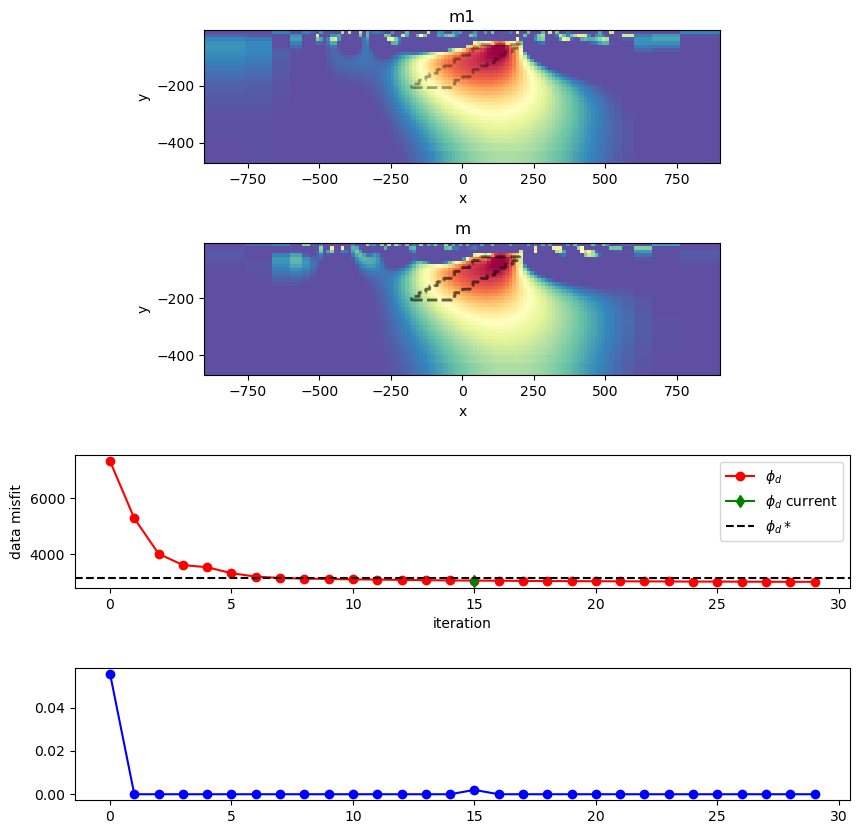

In [61]:
# fig, ax = plt.subplots(1,1)

# mm = meshCore.plot_image(

#     xp,
#     ax=ax,
#     pcolorOpts={'cmap':'Spectral_r'}

# )
ii = 15
m = np.load(f'admm_iter_tv_1e-3/model_{ii}.npy')
z = np.load(f'admm_iter/z_variabe_{ii}.npy')

m2 = np.load(f'iterations_l2_practical/model_{14}.npy')
m1 = np.load(f'admm_iter/model_{ii}.npy')


fig, ax = plt.subplots(4, 1, figsize=(10, 10))
meshCore.plot_image(1/ np.exp(m1), ax=ax[0], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
meshCore.plot_image(1/ np.exp(m), ax=ax[1], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_title('m1')
ax[1].set_title('m')
# ax[2].hist(m - z, 100)
# ax[2].set_title('contraint (m - z = 0)')
# ax[2].hist(1/ np.exp(m), 100, label='z', alpha=0.4)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--', 'alpha':0.2},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--', 'alpha':0.2},
    method='nearest'
    
)
utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--', 'alpha':0.2},
    method='nearest'
    
)
ax[2].plot(phi_d, '-or', label=r'$\phi_d$')
ax[2].plot(ii, phi_d[ii], '-dg', label=r'$\phi_d$ current')
ax[3].plot(contraint, '-ob', label=r'$\|m-z\|_2$')
ax[2].axhline(dc_data.dobs.shape[0], color='k', linestyle='--', label=r'$\phi_d*$')
# ax[2].set_ylim([0, 3000])
ax[2].legend()
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('data misfit')
plt.subplots_adjust(hspace=0.6, wspace=0.5)
plt.show()

## Plotting ADMM Inversion Results

Loaded dictionary: {'phi_d': [7316.82739104507, 5280.1443201583825, 4018.0324169612545, 3616.0423333538333, 3538.4202658178133, 3326.6980423741084, 3204.427765585864, 3156.5344537454093, 3133.269090204425, 3120.6369402024998, 3104.892540237795, 3099.989464265737, 3085.755330016437, 3077.716971486928, 3068.397973143867, 3062.7862643797125, 3058.9530315325846, 3050.6514539641694, 3046.1044669574217, 3043.4741567335523, 3039.752901343293, 3036.783270981344, 3034.3766696218754, 3032.0730289877165, 3028.0726941644325, 3027.6112356749686, 3023.929557845664, 3021.558776690303, 3019.438290866507, 3018.6279894920854], 'beta': 1.0, 'gamma': 0.001, 'norm_residual': [0.055695601262595804, 1.538370149106851e-15, 8.881784197001252e-16, 2.432376777795247e-15, 8.881784197001252e-16, 1.6616296724220897e-15, 1.6616296724220897e-15, 8.881784197001252e-16, 1.336885555457667e-15, 8.95090418262362e-16, 1.538370149106851e-15, 1.5423711185402538e-15, 1.2560739669470201e-15, 1.4043333874306805e-15, 1.986027322

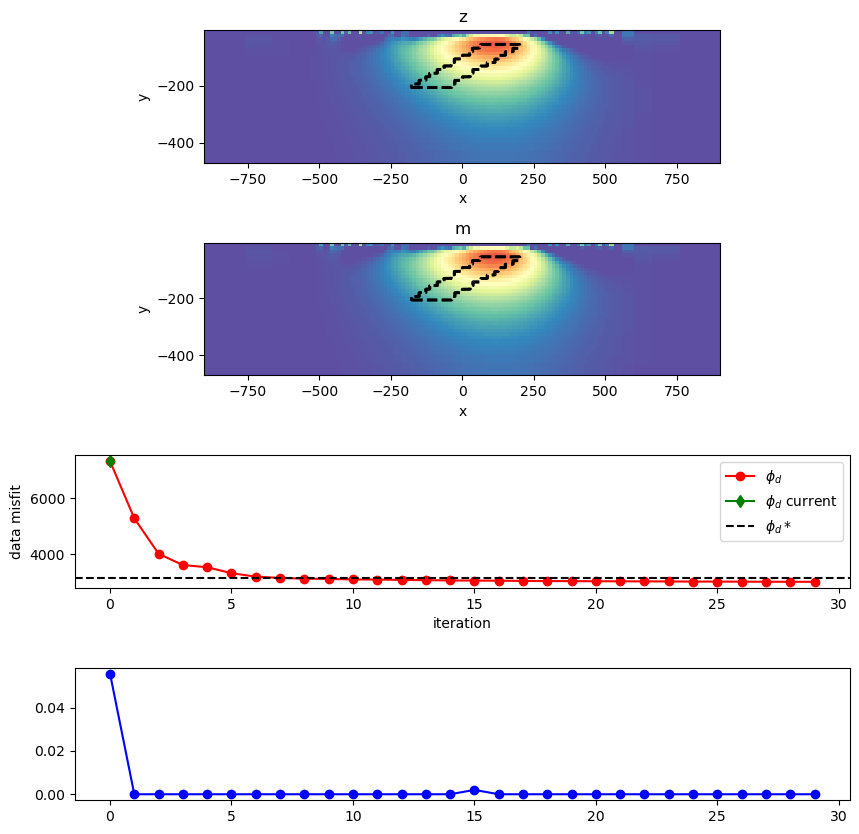

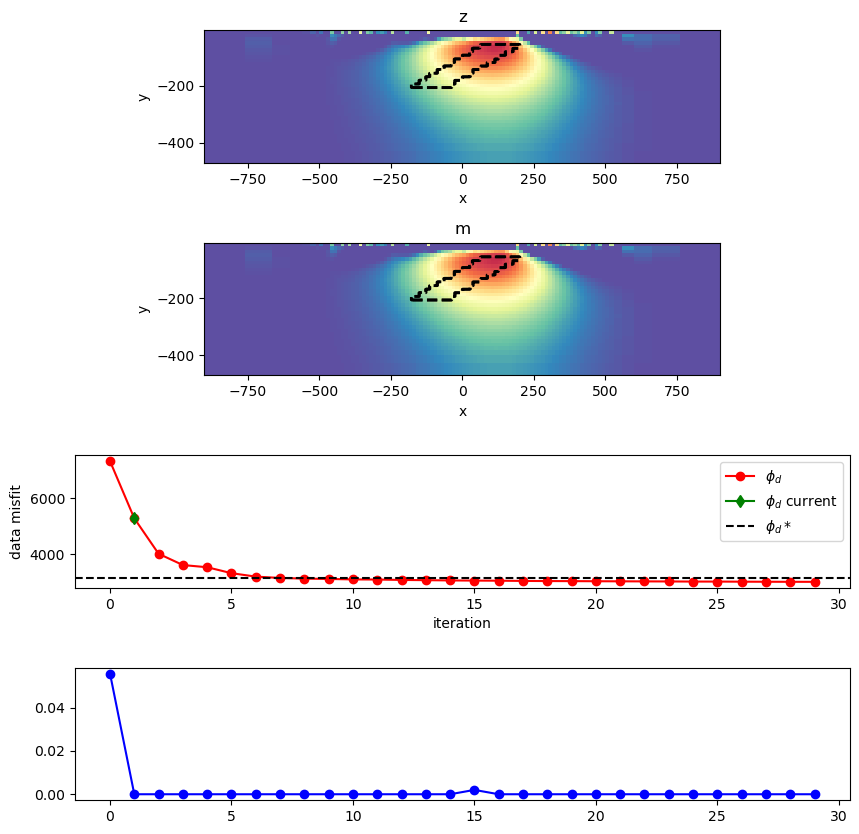

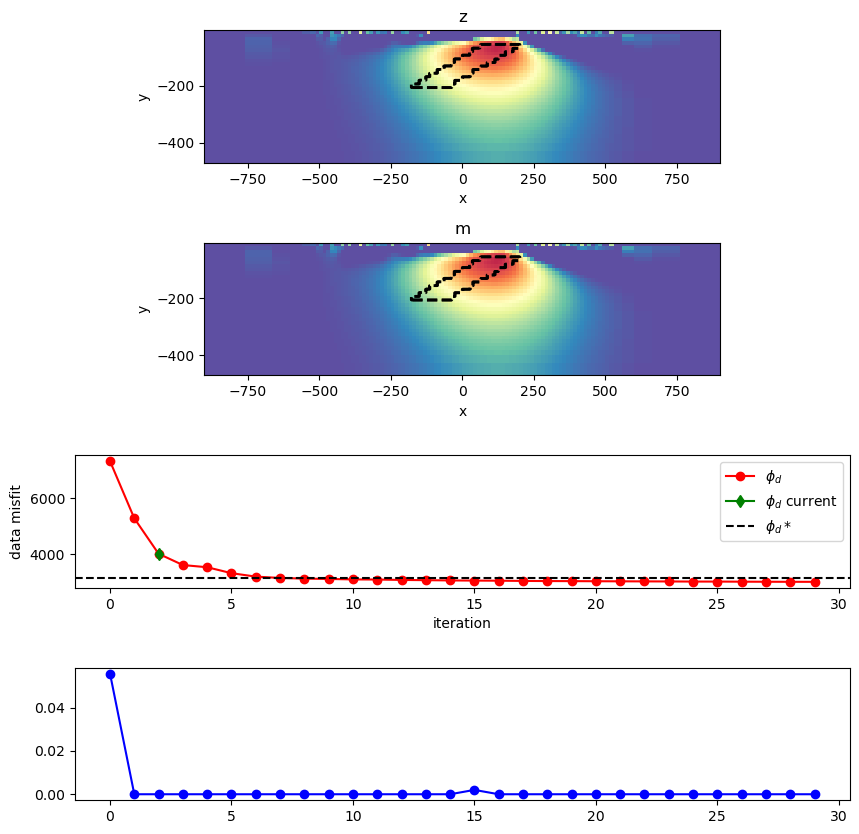

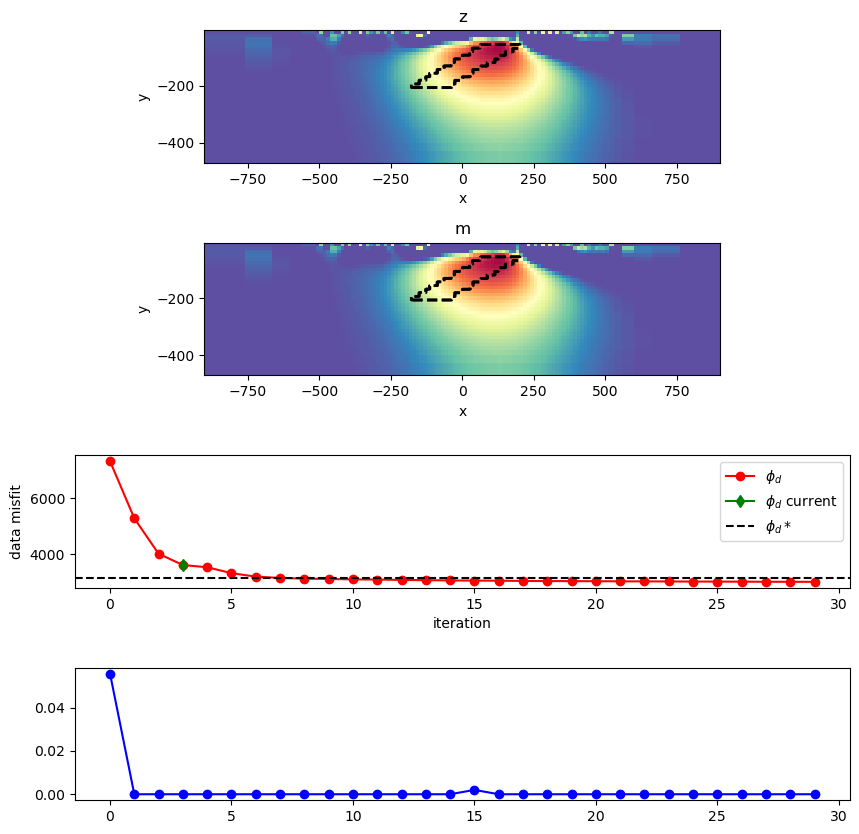

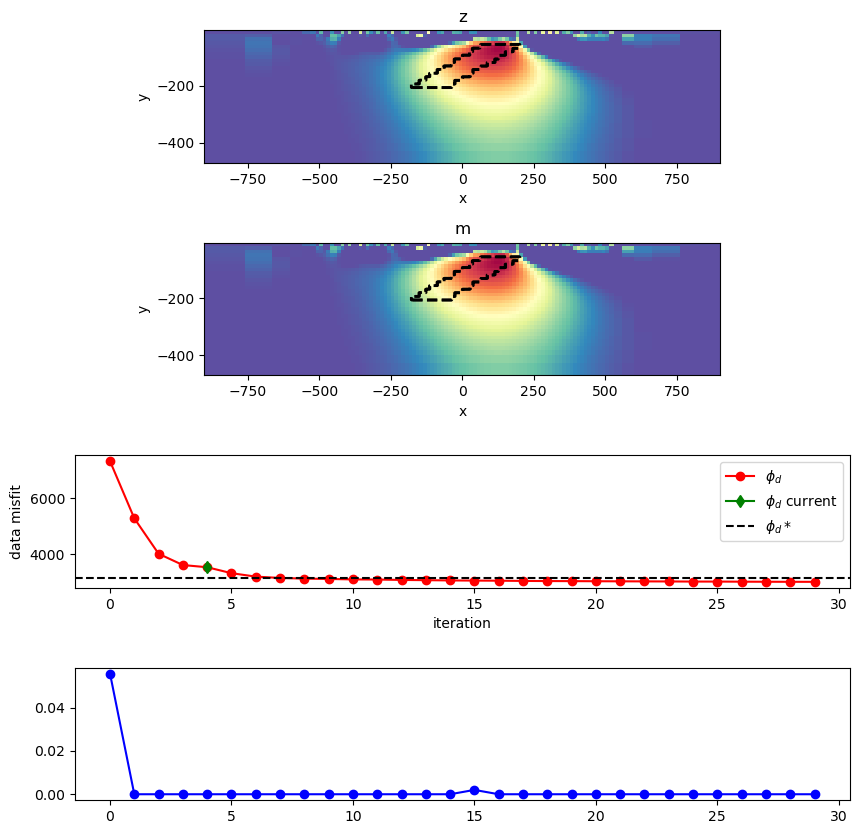

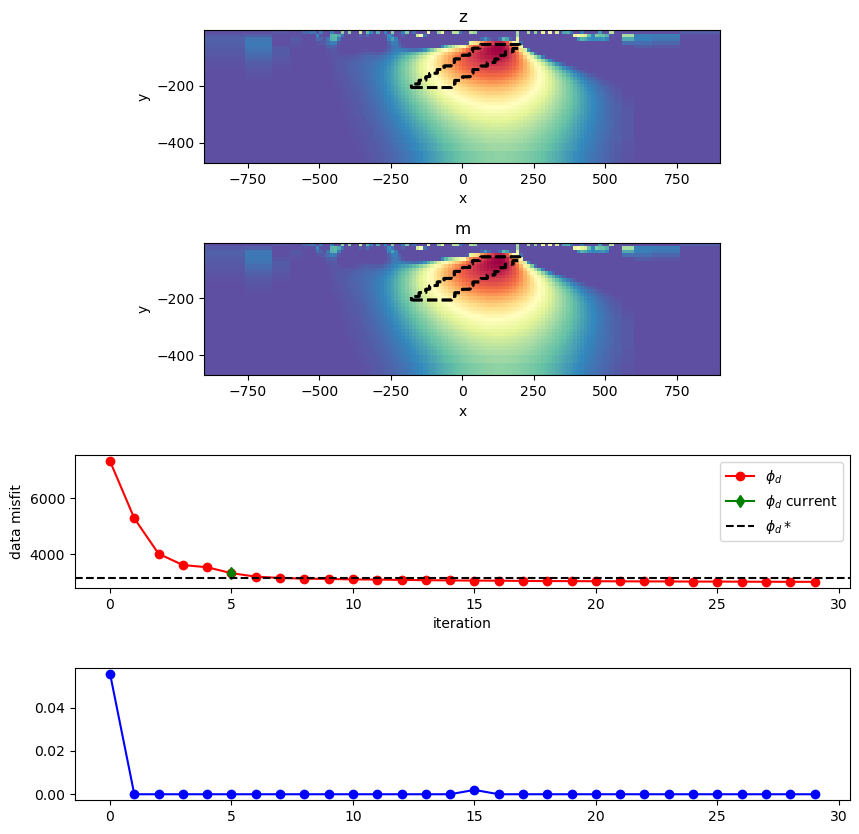

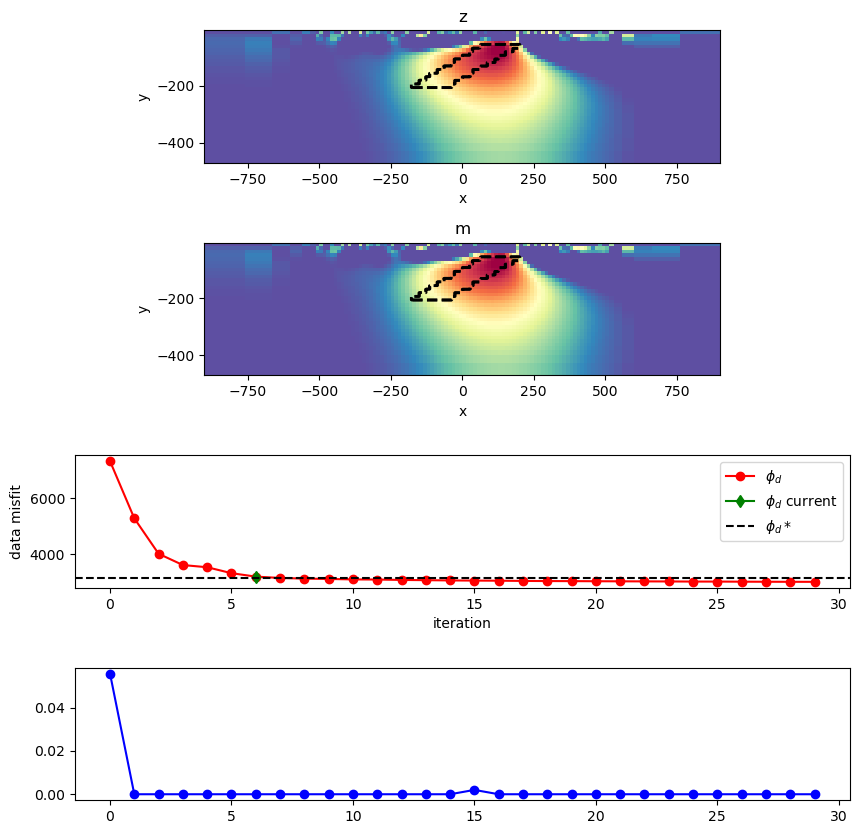

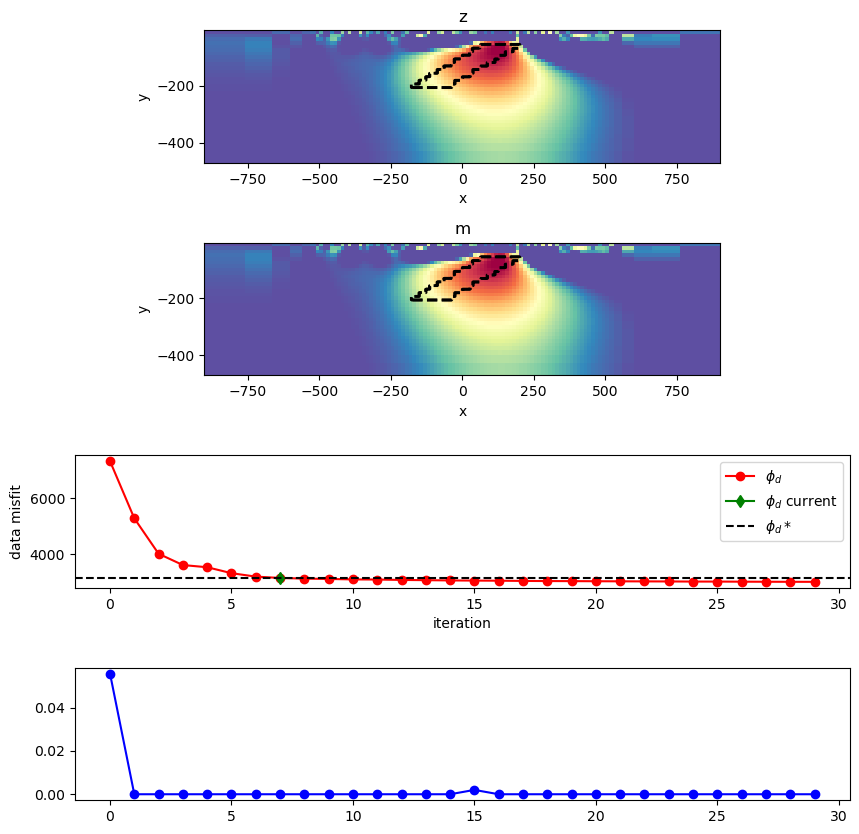

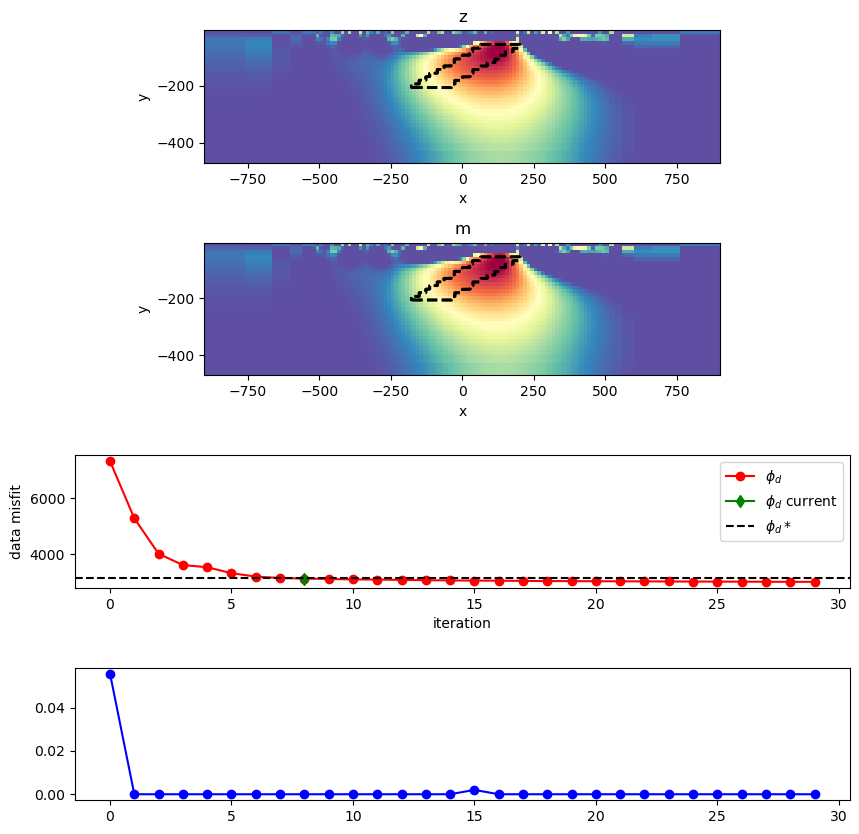

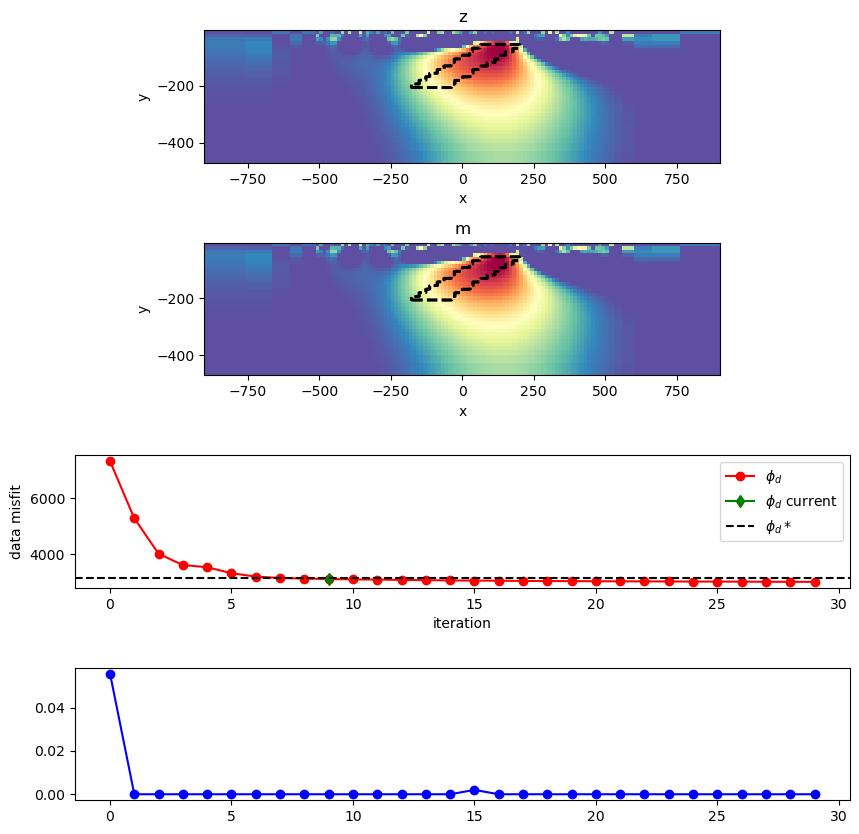

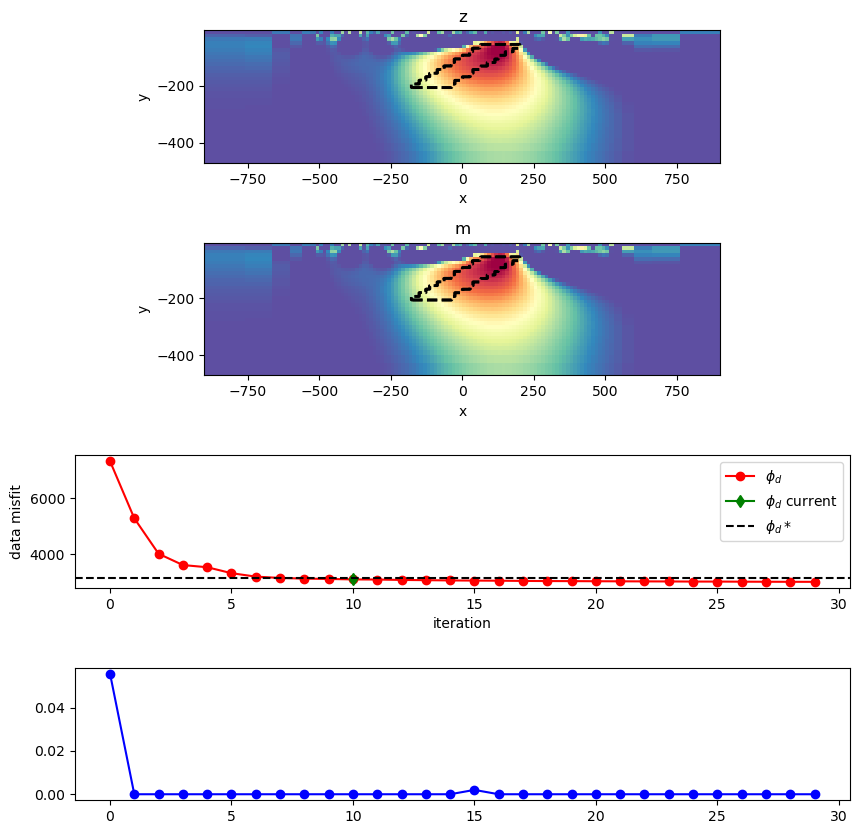

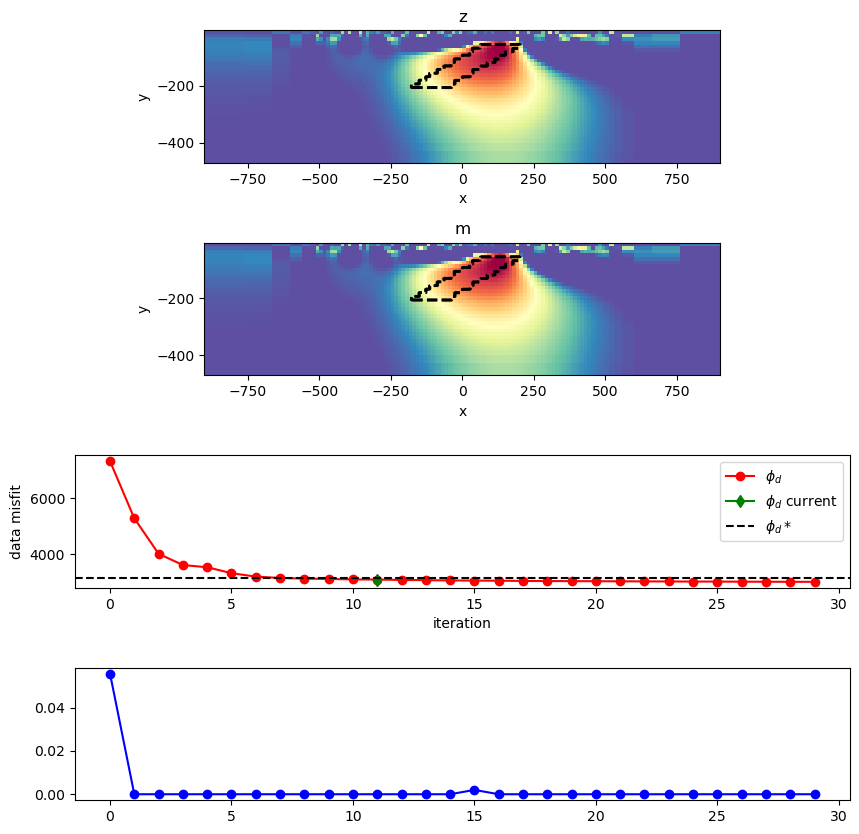

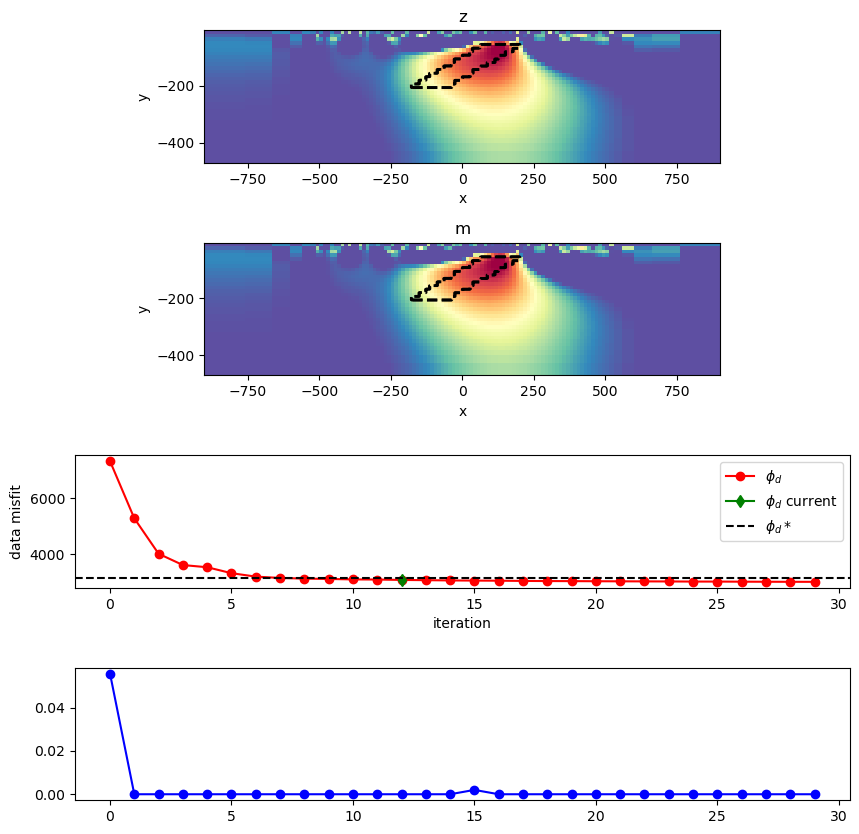

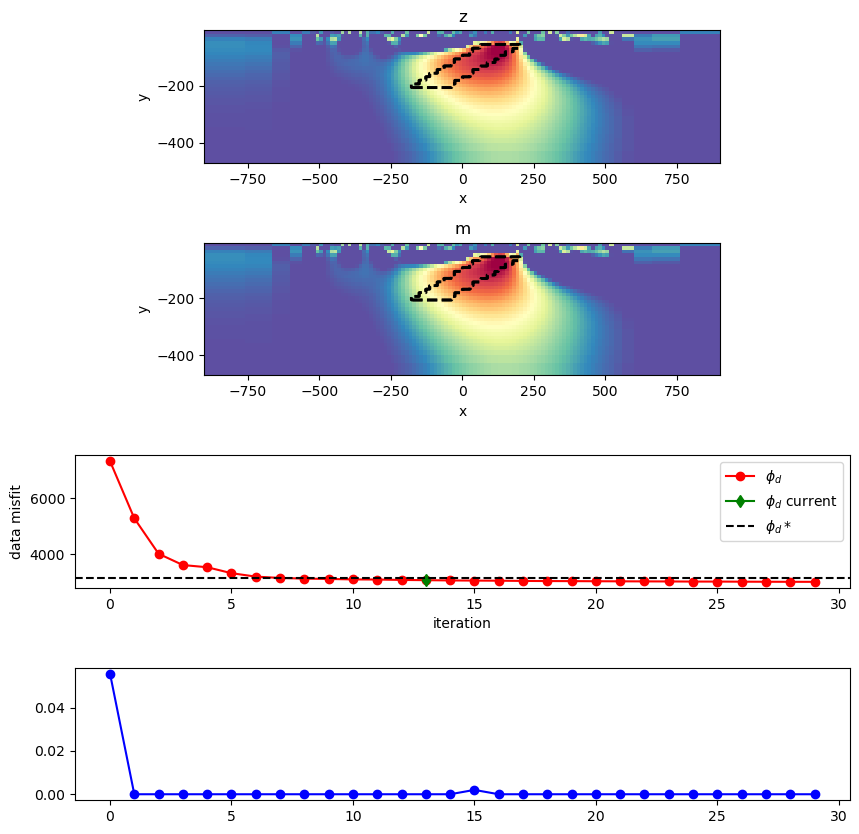

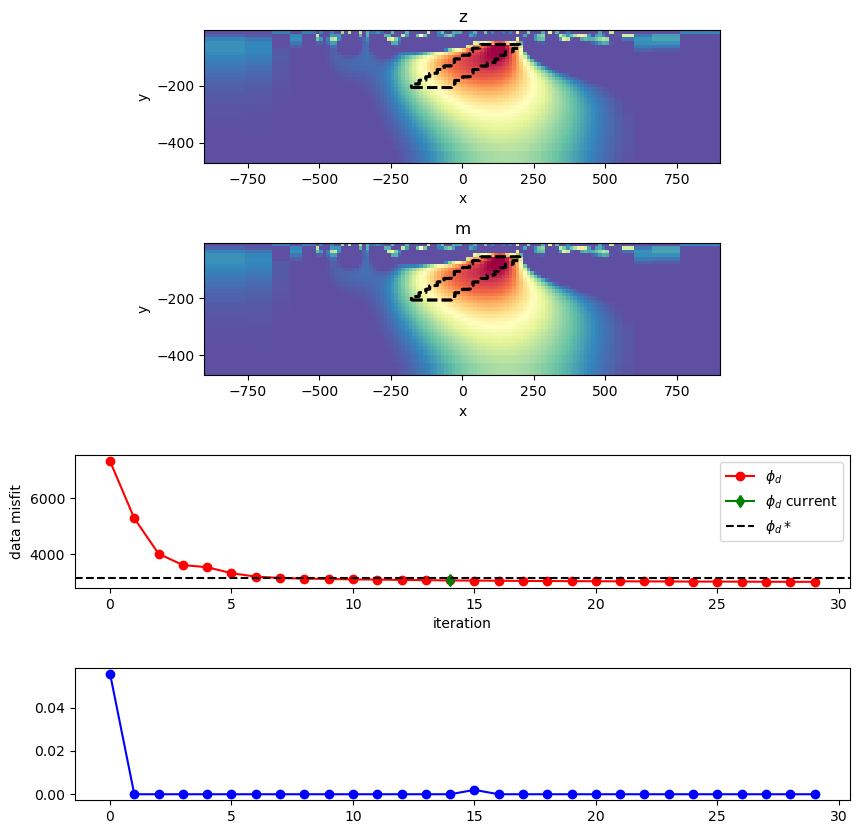

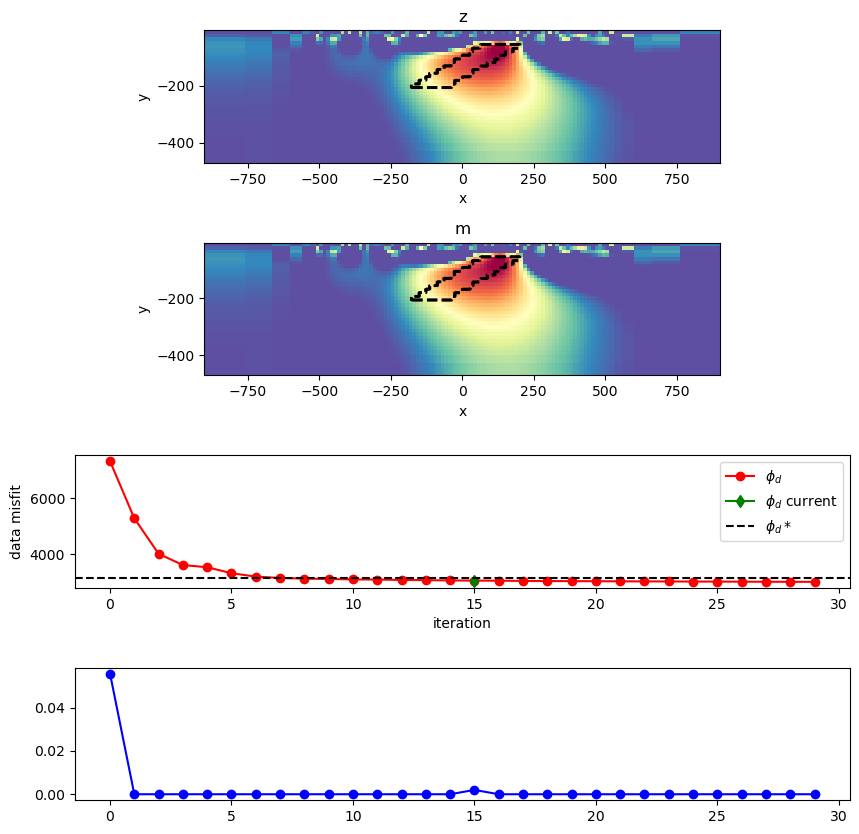

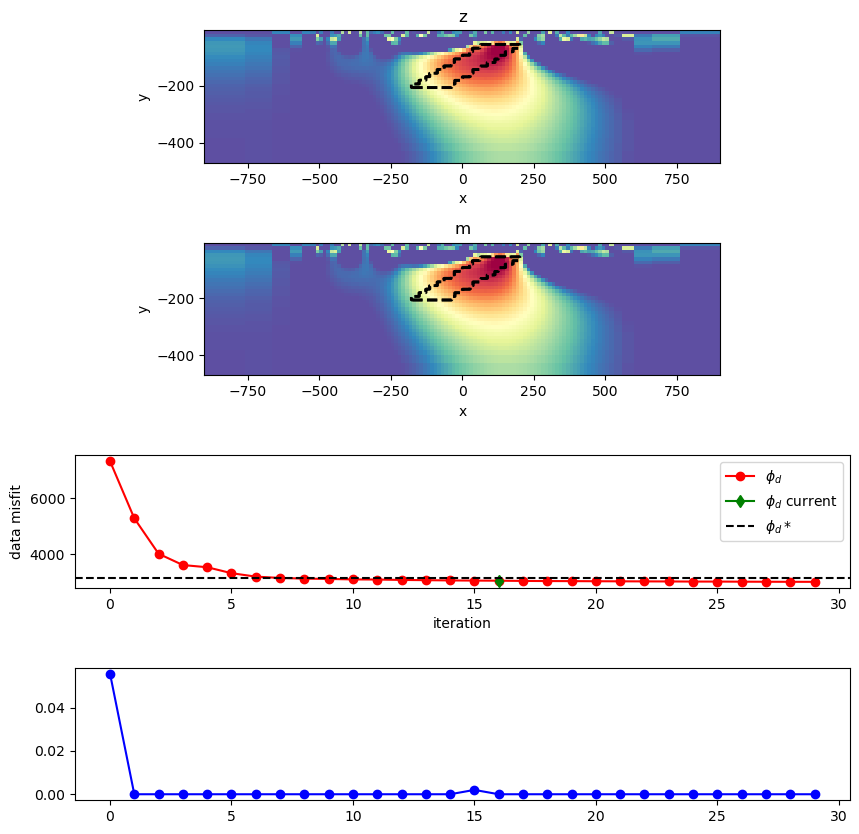

KeyboardInterrupt: 

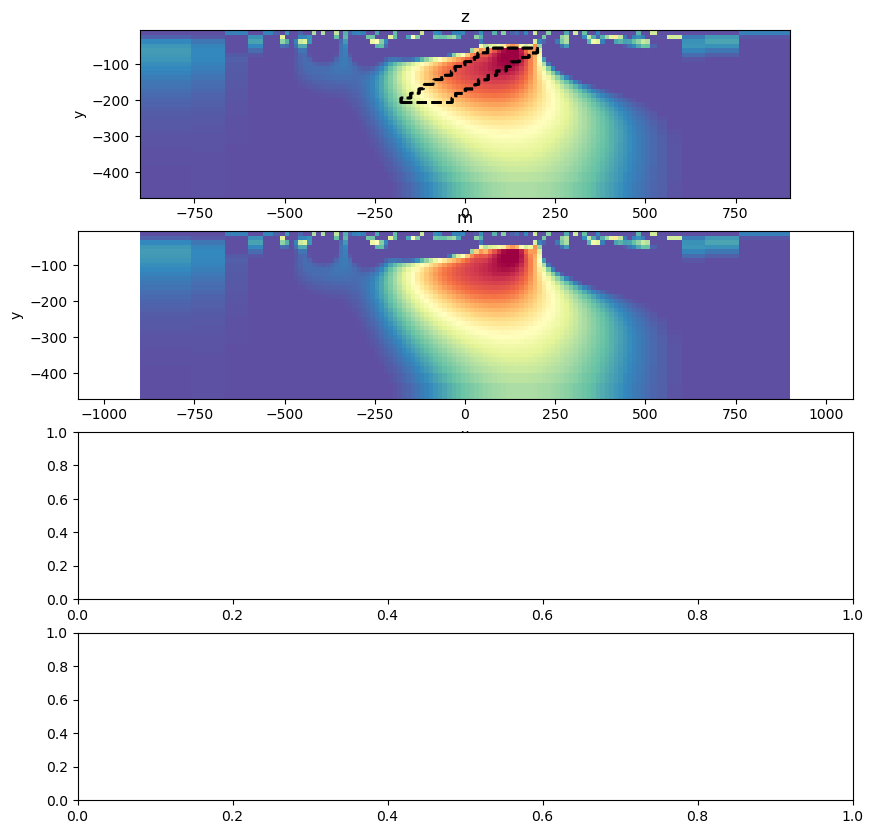

In [62]:
# phi_d = []
errors = []
u = np.zeros_like(mtrue[actcore])
import json

# Load dictionary from a JSON file
with open('admm_iter/phi_d.json', 'r') as file:
    loaded_data = json.load(file)

print("Loaded dictionary:", loaded_data)
phi_d = loaded_data['phi_d']
contraint = loaded_data['norm_residual']
ii = 0
for ii in range(30):
    
    m = np.load(f'admm_iter/model_{ii}.npy')
    z = np.load(f'admm_iter/z_variabe_{ii}.npy')
    u += m - z
    # phi_d += [dmis(m)]
    # errors += [np.linalg.norm(u)]
    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    meshCore.plot_image(1/ np.exp(z), ax=ax[0], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
    meshCore.plot_image(1/ np.exp(m), ax=ax[1], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
    ax[0].axis('equal')
    ax[1].axis('equal')
    ax[0].set_title('z')
    ax[1].set_title('m')
    # ax[2].hist(m - z, 100)
    # ax[2].set_title('contraint (m - z = 0)')
    # ax[2].hist(1/ np.exp(m), 100, label='z', alpha=0.4)

    utils.plot2Ddata(

        meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
        contourOpts={'alpha':0},
        #clim=[0,5],
        ax=ax[0],
        level=True,
        ncontour=2,
        levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        method='nearest'
        
    )

    utils.plot2Ddata(

        meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
        contourOpts={'alpha':0},
        #clim=[0,5],
        ax=ax[1],
        level=True,
        ncontour=2,
        levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        method='nearest'
        
    )
    ax[2].plot(phi_d, '-or', label=r'$\phi_d$')
    ax[2].plot(ii, phi_d[ii], '-dg', label=r'$\phi_d$ current')
    ax[3].plot(contraint, '-ob', label=r'$\|m-z\|_2$')
    ax[2].axhline(dc_data.dobs.shape[0], color='k', linestyle='--', label=r'$\phi_d*$')
    # ax[2].set_ylim([0, 3000])
    ax[2].legend()
    ax[2].set_xlabel('iteration')
    ax[2].set_ylabel('data misfit')
    plt.subplots_adjust(hspace=0.6, wspace=0.5)
    plt.show()

## This is something else

In [ ]:
models_geo = '/home/juanito/Documents/git/StructuralGeo/code_examples/model_test3_1.npy'
models_geo_locs = '/home/juanito/Documents/git/StructuralGeo/code_examples/model_test3_locs_1.npy'

geo_model = np.load(models_geo)
geo_model_locs = np.load(models_geo_locs)
print(geo_model_locs*25, geo_model_locs.shape, meshCore.cell_centers)

[[-500.      -500.      -250.     ]
 [-500.      -500.      -246.06299]
 [-500.      -500.      -242.12599]
 ...
 [ 500.       500.       242.12599]
 [ 500.       500.       246.06299]
 [ 500.       500.       250.     ]] (2097152, 3) [[-395. -295.]
 [-390. -295.]
 [-385. -295.]
 ...
 [ 385.   -5.]
 [ 390.   -5.]
 [ 395.   -5.]]


In [ ]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 12.5,  12.5,  12.5
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#


xmin, xmax = -1000., 1000.
ymin, ymax = -500., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones_like(actcore)


  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -5,846.74      5,846.74     12.50  1,621.83    1.50
   y     73     -5,584.24          6.25     12.50  1,621.83    1.50




16384


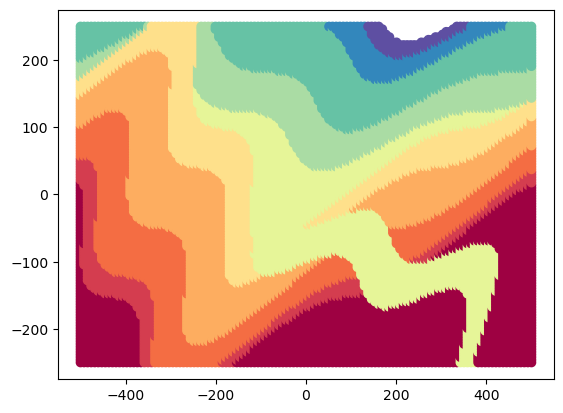

In [ ]:
inds = geo_model_locs[:,1] * 25 == 500
print(inds.sum())
plt.scatter(geo_model_locs[inds,0]*25, geo_model_locs[inds,2]*25, c=geo_model[inds], cmap='Spectral')

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Define the original data points
x = geo_model_locs[inds,0]*25
y = geo_model_locs[inds,2]*25 - np.max(geo_model_locs[inds,2]*25) + 50
values = geo_model[inds]

# Define the new points to interpolate to
new_x = mesh.cell_centers[:,0]
new_y = mesh.cell_centers[:,1]

# Combine x and y into a single array of points
points = np.vstack((x, y)).T

# New points where we want to interpolate the values
new_points = np.vstack((new_x, new_y)).T

# Initialize the NearestNeighbors model
nn = NearestNeighbors(n_neighbors=1)
nn.fit(points)

# Find the nearest neighbors for each new point
distances, indices = nn.kneighbors(new_points)

# Use the indices to get the corresponding values from the original data
interpolated_values = values[indices.flatten()]
# Print the interpolated values
print(interpolated_values)

[1. 1. 1. ... 9. 9. 9.]


In [ ]:
physy_model = np.zeros_like(mesh.cell_centers[:,0]) + 2000

inds_res_bottom = interpolated_values == 6
inds_res_bottom2 = interpolated_values == 5
inds_res_bottom3 = interpolated_values == 4
inds_res_core = interpolated_values == 7
inds_res_lid = interpolated_values == 8

physy_model[inds_res_bottom] = 500
physy_model[inds_res_bottom2] = 300
physy_model[inds_res_bottom3] = 1000
physy_model[inds_res_core] = 10
physy_model[inds_res_lid] = 800



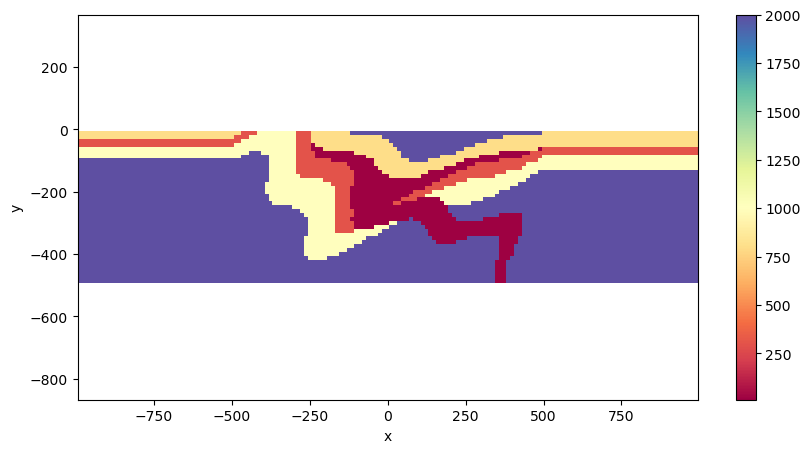

(13651,) 6201


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
dd = meshCore.plot_image(physy_model[actcore], ax=ax, pcolor_opts={'cmap':'Spectral'})
plt.colorbar(dd[0])
plt.axis('equal')
plt.show()
print(interpolated_values.shape, meshCore.nC)

# np.save('complex_model.npy', physy_model)

In [ ]:
xmin, xmax = -750., 750.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in [50]:

    print(f'adding dipole size: {dipole}')
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=30,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=30,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.01
dc_data = simulation.make_synthetic_data(
    
    np.log(physy_model[actcore]),
    relative_error=relative_measurement_error,
    noise_floor=6e-3,
    force=True,
    add_noise=True,

)

# dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.1)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())

adding dipole size: 50


/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


0.3214913041811542
643.5097681703803


0.3214913041811542
643.5097681703803
1.5198634191705784 0.000531095671679305
5.518911208002285


Text(0.5, 1.0, 'Relative Error ($\\frac{\\sigma^{2}}{d_{obs}}$)')

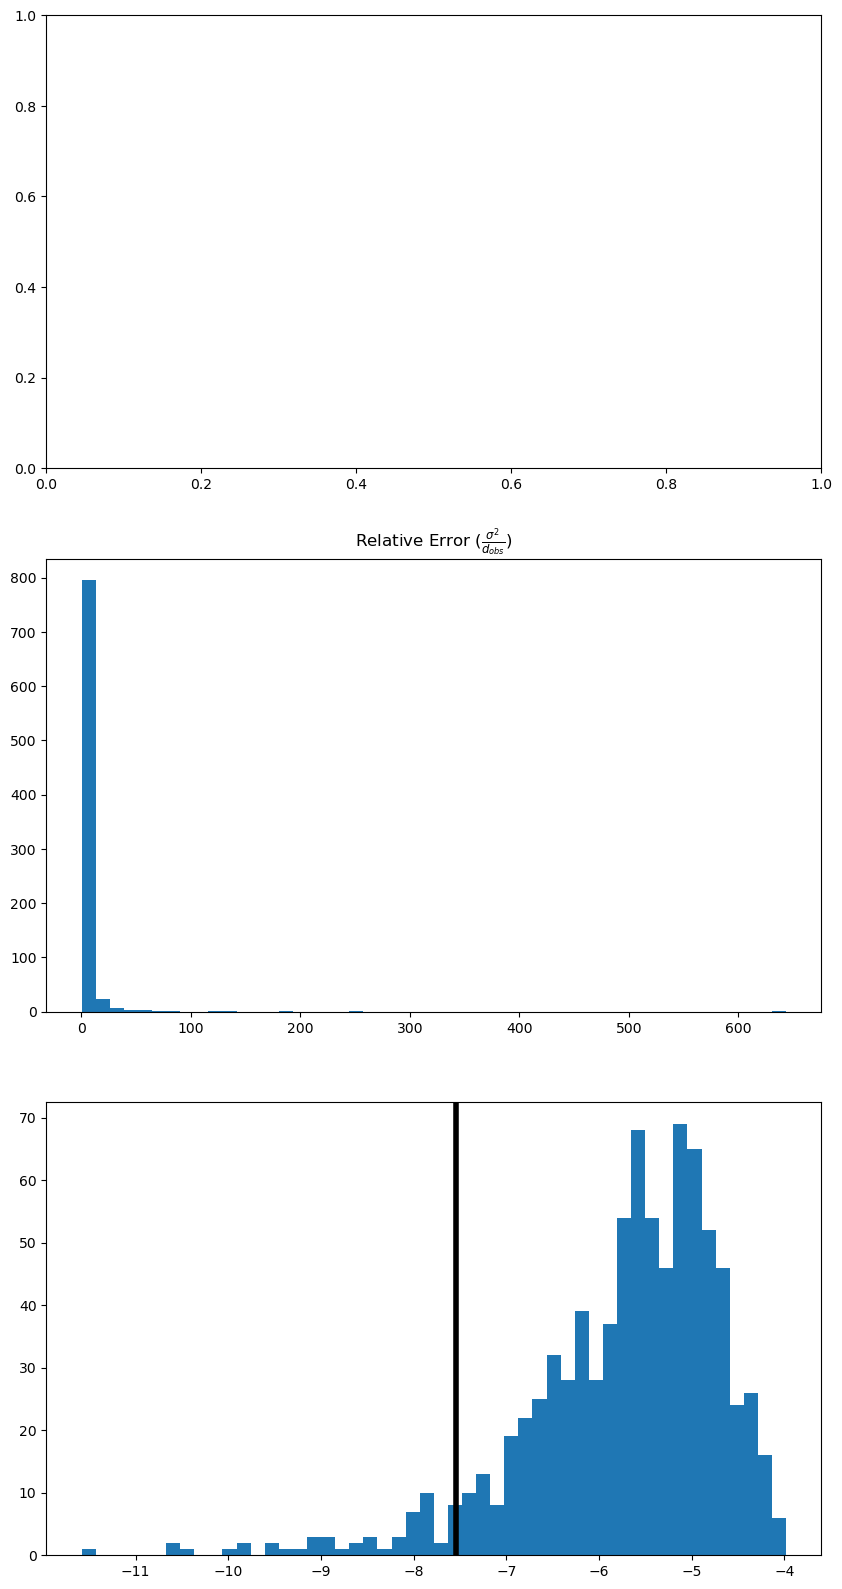

In [ ]:
fig,ax = plt.subplots(3, 1,figsize=(10,20))
relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list), np.quantile(np.abs(dc_data.dobs), 0.06))
print(relative_error_list.mean())
ax[1].hist(relative_error_list, 50)
ax[2].hist(np.log(np.abs(dc_data.dobs)), 50)
ax[2].axvline(np.log(np.quantile(np.abs(dc_data.dobs), 0.06)), color='k', linewidth=4)
ax[1].set_title(r'Relative Error ($\frac{\sigma^{2}}{d_{obs}}$)')

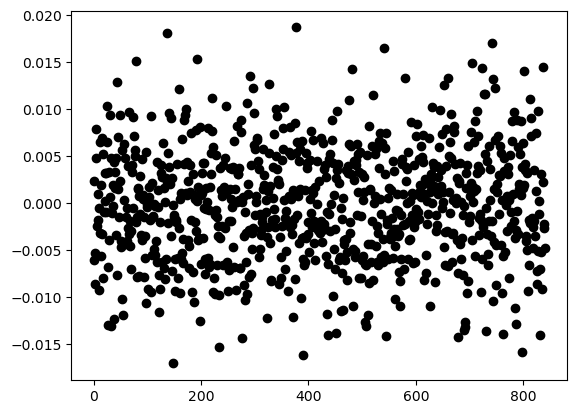

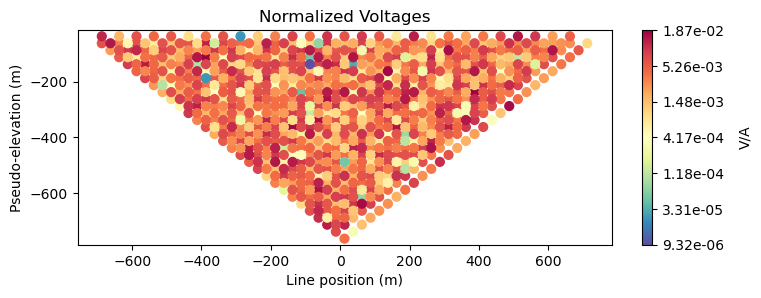

In [ ]:
plt.plot(dc_data.dobs, 'ok')

from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=dc_data.dobs,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": 'Spectral_r'},
)
ax1.set_title("Normalized Voltages")
plt.show()